# Fitting Gaussian Mixture Models with EM

In this tutorial, which was originated from coursera machine learning course by university of washington, you will
* implement the EM algorithm for a Gaussian mixture model
* apply your implementation to cluster images
* explore clustering results and interpret the output of the EM algorithm  

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline


## Implementing the EM algorithm for Gaussian mixture models

In this section, you will implement the EM algorithm. We will take the following steps:

- Create some synthetic data.
- Provide a log likelihood function for this model.
- Implement the EM algorithm.
- Visualize the progress of the parameters during the course of running EM.
- Visualize the convergence of the model.

### Dataset

To help us develop and test our implementation, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

Now we will create a function to generate data from a mixture of Gaussians model. 

In [2]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

After specifying a particular set of clusters (so that the results are reproducible across assignments), we use the above function to generate a dataset.

In [4]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

Now plot the data you created above. The plot should be a scatterplot with 100 points that appear to roughly fall into three clusters.

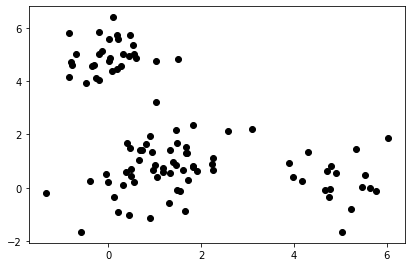

In [5]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [6]:
data

[array([0.31845368, 5.03182099]),
 array([1.45029339, 2.15717573]),
 array([1.02645431, 4.76042375]),
 array([ 5.23493625, -0.81138851]),
 array([ 4.65710743, -0.08532351]),
 array([0.43746553, 4.93778385]),
 array([-0.12756373,  5.14296293]),
 array([4.18200738, 0.24819247]),
 array([ 1.65646672, -0.87991369]),
 array([-0.69508006,  5.03848976]),
 array([6.01348014, 1.87722666]),
 array([ 0.20099208, -0.93213203]),
 array([-0.38268222,  0.26365374]),
 array([ 5.03394554, -1.66740986]),
 array([ 1.53889119, -0.12731715]),
 array([0.81448617, 1.63543709]),
 array([1.7219243 , 0.28460715]),
 array([4.90757786, 0.56716088]),
 array([0.60512066, 4.87555125]),
 array([ 1.30867865, -0.58711045]),
 array([0.19570654, 5.73836612]),
 array([3.97078181, 0.39328234]),
 array([0.47190777, 1.47637309]),
 array([1.32157017, 0.56486368]),
 array([3.89988459, 0.92433204]),
 array([0.11205488, 6.4072012 ]),
 array([0.40717315, 1.67134485]),
 array([0.56231532, 5.01349864]),
 array([1.82113515, 0.788922

### Log likelihood 
We provide a function to calculate log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model. We will use this to assess convergence of our EM algorithm; specifically, we will keep looping through EM update steps until the log likehood ceases to increase at a certain rate.

In [7]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

### Implementation

You will now complete an implementation that can run EM on the data you just created. It uses the `loglikelihood` function we provided above.

Hint: Some useful functions

* [multivariate_normal.pdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html): lets you compute the likelihood of seeing a data point in a multivariate Gaussian distribution.
* [np.outer](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html): comes in handy when estimating the covariance matrix from data.

In [8]:
# SOLUTION
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # Your code 
                resp[j, k] =  weights[k] * multivariate_normal.pdf(data[j], mean=means[k], cov=covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            weights[k] = counts[k]
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            
            weighted_sum = 0
            for j in range(num_data):
                # Your code: weighted_sum 
                weighted_sum += data[j] * resp[j,k]
            means[k] = weighted_sum / weights[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                #(Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += np.outer(data[j] - means[k],data[j] - means[k]) * resp[j,k]
                
            covariances[k] = weighted_sum / weights[k]

        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    weights = weights / sum(weights)
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

### Testing the implementation on the simulated data

Now we'll fit a mixture of Gaussians to this data using our implementation of the EM algorithm. As with k-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, we'll take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters.

In [9]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3
# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


**Note**. Like k-means, EM is prone to converging to a local optimum. In practice, you may want to run EM multiple times with different random initialization. We have omitted multiple restarts to keep the assignment reasonably short. For the purpose of this assignment, we assign a particular random seed (`seed=4`) to ensure consistent results among the students.

**Checkpoint**. For this particular example, the EM algorithm is expected to terminate in 23 iterations. That is, the last line of the log should say "Iteration 22". If your function stopped too early or too late, you should re-visit your code.

Our algorithm returns a dictionary with five elements: 
* 'loglik': a record of the log likelihood at each iteration
* 'resp': the final responsibility matrix
* 'means': a list of K means
* 'covs': a list of K covariance matrices
* 'weights': the weights corresponding to each model component

**Quiz Question**: What is the weight that EM assigns to the first component after running the above codeblock?

**Answer: ** 30.07

In [10]:
results['weights']

array([0.30071023, 0.1799371 , 0.51935267])

**Quiz Question**: Using the same set of results, obtain the mean that EM assigns the second component. What is the mean in the first dimension?

**Answer:** 4.94239235

In [11]:
results['means']

[array([0.02138285, 4.947729  ]),
 array([4.94239235, 0.31365311]),
 array([1.08181125, 0.73903508])]

**Quiz Question**: Using the same set of results, obtain the covariance that EM assigns the third component. What is the variance in the first dimension?

**Answer:**0.67114992

In [12]:
results['covs'][2]

array([[0.67114992, 0.33058965],
       [0.33058965, 0.90429724]])

### Plot progress of parameters

One useful feature of testing our implementation on low-dimensional simulated data is that we can easily visualize the results. 

We will use the following `plot_contours` function to visualize the Gaussian components over the data at three different points in the algorithm's execution:

1. At initialization (using initial_mu, initial_cov, and initial_weights)
2. After running the algorithm to completion 
3. After just 12 iterations (using parameters estimates returned when setting `maxiter=12`)

In [13]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [14]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

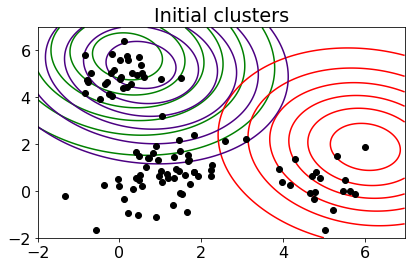

In [15]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


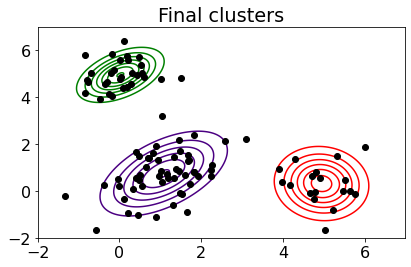

In [24]:
# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Fill in the following code block to visualize the set of parameters we get after running EM for 12 iterations.

Iteration 0
Iteration 5
Iteration 10
Iteration 11


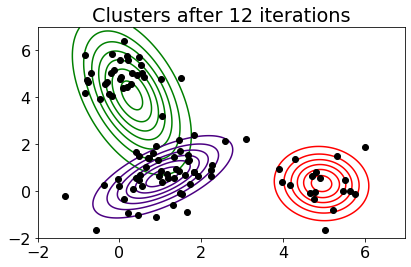

In [25]:
results = EM(data, initial_means, initial_covs, initial_weights, maxiter=12)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

**Quiz Question**: Plot the loglikelihood that is observed at each iteration. Is the loglikelihood plot monotonically increasing, monotonically decreasing, or neither? 

**Answer: ** monotonically increasing

In [17]:
results = EM(data, initial_means, initial_covs, initial_weights)
loglikelihoods = results['loglik']

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


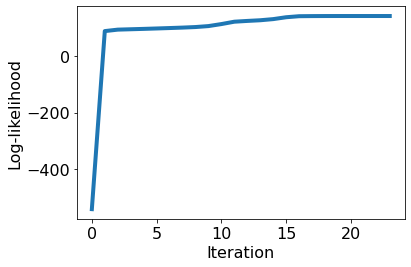

In [18]:
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()